In [1]:
import random, math, gym
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

import matplotlib.pyplot as plt
import time
from IPython import display
%matplotlib notebook

/home/nathan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#-------------------- BRAIN ---------------------------

class Brain:
    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.model = self._createModel()
        # self.model.load_weights("cartpole-basic.h5")

    def _createModel(self):
        model = Sequential()

        model.add(Dense(output_dim=64, activation='relu', input_dim=stateCnt))
        model.add(Dense(output_dim=actionCnt, activation='linear'))

        opt = RMSprop(lr=0.00025)
        model.compile(loss='mse', optimizer=opt)

        return model

    def train(self, x, y, epoch=1, verbose=0):
        self.model.fit(x, y, batch_size=64, nb_epoch=epoch, verbose=verbose)

    def predict(self, s):
        return self.model.predict(s)

    def predictOne(self, s):
        return self.predict(s.reshape(1, self.stateCnt)).flatten()

#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ )
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

#-------------------- AGENT ---------------------------
MEMORY_CAPACITY = 100000
BATCH_SIZE = 64

GAMMA = 0.99

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.001      # speed of decay

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s):
        if random.random() < self.epsilon:
            return random.randint(0, self.actionCnt-1)
        else:
            return np.argmax(self.brain.predictOne(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):    
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = np.zeros(self.stateCnt)

        states = np.array([ o[0] for o in batch ])
        states_ = np.array([ (no_state if o[3] is None else o[3]) for o in batch ])

        p = self.brain.predict(states)
        p_ = self.brain.predict(states_)

        x = np.zeros((batchLen, self.stateCnt))
        y = np.zeros((batchLen, self.actionCnt))
        
        for i in range(batchLen):
            o = batch[i]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]
            
            t = p[i]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * np.amax(p_[i])

            x[i] = s
            y[i] = t

        self.brain.train(x, y)

#-------------------- ENVIRONMENT ---------------------
class Environment:
    def __init__(self, problem):
        self.problem = problem
        self.env = gym.make(problem)

    def run(self, agent):
        s = self.env.reset()
        R = 0 

        while True:            
            self.env.render()

            a = agent.act(s)

            s_, r, done, info = self.env.step(a)

            if done: # terminal state
                s_ = None

            agent.observe( (s, a, r, s_) )
            agent.replay()            

            s = s_
            R += r

            if done:
                break

        print("Total reward:", R)

In [9]:
class Environment2:
    def __init__(self, grid_size):
        self.grid_size = grid_size
        
    def run(self, agent):
        self.reset()
        s = self.state
        R = 0 

        while True:            
            self.render()

            a = agent.act(s)

            s_, r, done = self.act(a)

            if done: # terminal state
                s_ = None

            agent.observe( (s, a, r, s_) )
            agent.replay()            

            s = s_
            R += r

            if done:
                break

        print("Total reward:", R)

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        # 0 = left
        # 1 = right
        # 2 = down
        # 3 = up
        
        fy, fx, py, px, t, d = state
        
        old_d = abs(fx - px) + abs(fy - py)
        
        if action == 0:
            if px > 0:
                px -= 1
        if action == 1:
            if px < self.grid_size-1:
                px += 1
        if action == 2:
            if py > 0:
                py-= 1
        if action == 3:
            if py < self.grid_size-1:
                py += 1
                
        new_d = abs(fx - px) + abs(fy - py)
        
        out = np.array([fy, fx, py, px, t-1, old_d-new_d])
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[state[2], state[3]] = 0.5  # draw basket
        self.canvas = canvas
        return canvas

    def _get_reward(self):
        fruit_y, fruit_x, player_y, player_x, t, d = self.state
        
        if fruit_x == player_x and fruit_y == player_y:
            return 1
        
        if d == 1:
            return 0.1
        
        if d == 0:
            return -0.1
        
        if d == -1:
            return -1


    def _is_over(self):
        fruit_y, fruit_x, player_y, player_x, t, d = self.state
        
        if t == 0:
            return True
        
        if fruit_x == player_x and fruit_y == player_y:
            return True
    
        return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))
    
    def render(self):
        self._draw_state()
        plt.gca().cla()
        plt.imshow(self.canvas)
        display.clear_output(wait=True)
        display.display(plt.gcf())

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.state, reward, game_over

    def reset(self):
        fruit_x = np.random.randint(0, self.grid_size-1)
        fruit_y = np.random.randint(0, self.grid_size-1)
        player_x = np.random.randint(0, self.grid_size-1)
        player_y = np.random.randint(0, self.grid_size-1)
        time = abs(fruit_x - player_x) + abs(fruit_y - player_y)
        time *= 2
        
        while abs(fruit_x - player_x) + abs(fruit_y - player_y) < self.grid_size/2:
            fruit_x = np.random.randint(0, self.grid_size-1)
            fruit_y = np.random.randint(0, self.grid_size-1)
            player_x = np.random.randint(0, self.grid_size-1)
            player_y = np.random.randint(0, self.grid_size-1)
            time = abs(fruit_x - player_x) + abs(fruit_y - player_y)
            time *= 2
            
        self.state = np.asarray([fruit_y, fruit_x, player_y, player_x, time, 0])
        self._draw_state()

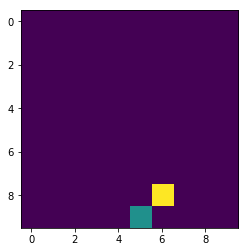

In [ ]:
#-------------------- MAIN ----------------------------
# PROBLEM = 'CartPole-v0'
# env = Environment(PROBLEM)

# stateCnt  = env.env.observation_space.shape[0]
# actionCnt = env.env.action_space.n

env = Environment2(10)
stateCnt = 6
actionCnt = 4

agent = Agent(stateCnt, actionCnt)

try:
    while True:
        env.run(agent)
finally:
    agent.brain.model.save("cartpole-basic.h5")